# Spatial Data Science I: Representing Spatial Data

In [1]:
import pandas as pd
import geopandas as gpd
import libpysal.api as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline

In [2]:
listings = pd.read_csv('./data/berlin-listings.csv.gz')
neighbourhoods = gpd.read_file('data/berlin-neighbourhoods.geojson').to_crs(epsg=3857)

### Converting flat text into geodata

In [3]:
listings['geometry'] = listings[['longitude','latitude']].apply(geom.Point, 
                                                                axis=1) #take each row

In [4]:
listings = gpd.GeoDataFrame(listings)
listings.crs={'init':'epsg:4269'}
listings = listings.to_crs(epsg=3857)

### Getting basemap info

In [5]:
basemap, bounds = ctx.bounds2img(*listings.total_bounds, zoom=10, 
                                 url='http://tile.stamen.com/toner-lite/tileZ/tileX/tileY.png')

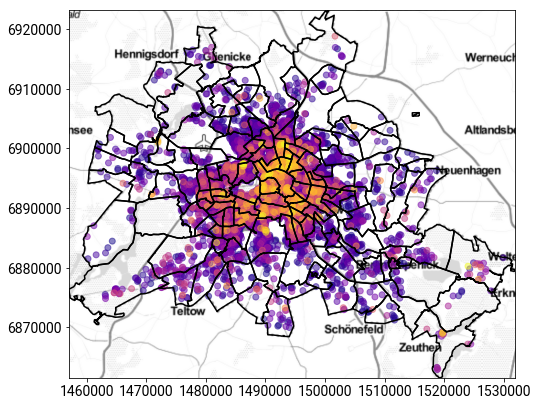

In [6]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
# when you only want to plot the boundaries:
neighbourhoods.boundary.plot(color='k', ax=ax)
#basemap of the area
ax.imshow(basemap, extent=bounds, interpolation='gaussian')
ax.axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
#if you want the highest values to show on top of lower ones
listings.sort_values('price').plot('price', ax=ax, marker='o', cmap='plasma', alpha=.5)

# Contiguity

Contiguity weights, or "adjacency matrices," are one common representation of spatial relationships that spring to mind when modeling how polygons relate to one another. In this representation, objects are considered "near" when they touch, and "far" when they don't; adjacency is considered as a "binary" relationship, so all polygons that are near to one another are *as near as they are to any other near polygon*; the weighting is binary. 

We've got fast algos to build these kinds of relationships from shapely/geopandas, as well as directly from files (without having to read all the data in at once). 

In [7]:
Qneighbs = lp.Queen.from_dataframe(neighbourhoods)

The `pysal` library is currently going under a bit of restructuring. 

But, the main components of the package are migrated to `libpysal`, which forms the base of a constellation of spatial data science packages. 

We'll focus on `libpysal` throughout the analysis; all of this functionality should be offered directly in `pysal` by the end of 2018. 

Given this, we you can plot the adjacency graph for the polygons we showed above as another layer in the plot. I'll remove some of the view to make the view simpler to examine:

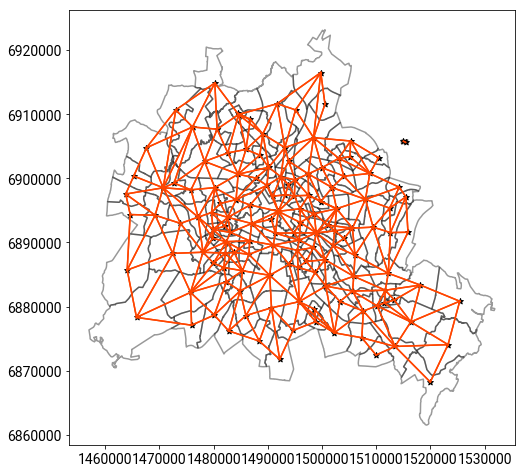

In [8]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
# when you only want to plot the boundaries:
neighbourhoods.boundary.plot(color='k', ax=ax, alpha=.4)
#basemap of the area
#ax.imshow(basemap, extent=bounds, interpolation='gaussian')
#ax.axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
#if you want the highest values to show on top of lower ones
#listings.sort_values('price').plot('price', ax=ax, marker='o', cmap='plasma', alpha=.5)
Qneighbs.plot(neighbourhoods, edge_kws=dict(linewidth=1.5, color='orangered'), node_kws=dict(marker='*'), ax=ax)
plt.show()

Often, having observations (or components) that are disconnected can make analyses poorly behaved. It looks like there may be some disconnected observations in our data, up in northeast Berlin.

We can check if individual observations are disconnected using the weights object's `islands` argument:

In [9]:
Qneighbs.islands

[]

There are no single observations that are disconnected, so it's probably more than one observation up in the northeast that are disconnected *from the rest of the graph. 

Let's look at this using `scipy`.

PySAL weights can be used in other packages by converting them into their equivalent matrix representations. Sparse and dense array versions are offered, with `.sparse` providing the sparse matrix representation, and `.full()` providing the ids and dense matrix representing the graphs. 

In [10]:
spqneighbs = Qneighbs.sparse
spqneighbs.eliminate_zeros()

Visualizing the matrix, you can see that the adjacency matrix is very sparse indeed:

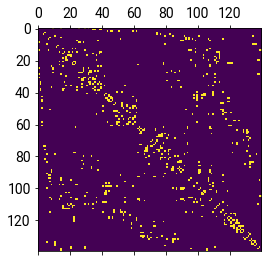

In [11]:
plt.matshow(spqneighbs.toarray())

We can get the number of links as a percentage of all possible $N^2$ links from:

In [12]:
Qneighbs.pct_nonzero

3.938775510204082

Which means that there are around 4% of all the possible connections between any two observations actually make it into the adjacency graph.

For contiguity matrices, this only has binary elements, recording 1 where two observations are linked. Everywhere else, the array is empty (zero, in a dense representation). 

In [13]:
np.unique(spqneighbs.data)

array([1.])

Fortunately for us, PySAL plays real well with scipy & other things built on top of SciPy. So, the [new compressed sparse graph (`csgraph`)](https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html) module in SciPy works wonders with the PySAL sparse weights representations. So, we often will jump back and forth between PySAL weights and scipy tools when working with these spatial representations of data. 

In [14]:
import scipy.sparse.csgraph as csgraph

Now, in `csgraph`, there are a ton of tools to work with graphs. For our purposes, if we just wanted to keep the big connected graph and drop the secondary small disconnected graph, we could use `csgraph.connected_components`:

In [15]:
number_connected, labels = csgraph.connected_components(spqneighbs)

And verify that there's only the two subgraphs that we see that are disconnected:

In [16]:
print(number_connected, labels)

2 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Yep! there are two components, one with two elements and another with all the rest. 

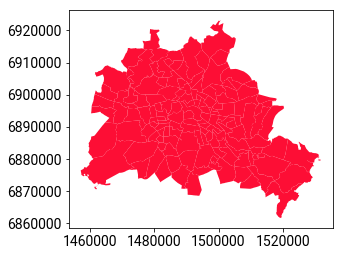

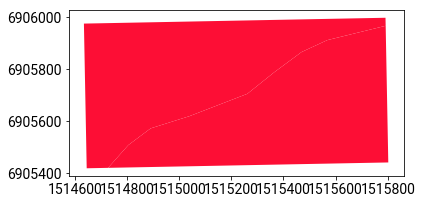

In [17]:
for label in range(0,2):
    neighbourhoods[labels == label].plot()
    plt.show()

So, this might be a digitzation error, or may be something else. 

Regardless, it's common to only want to focus on the connected parts at one time; to get there, we'll subset the dataframe and rebuild the weights:

In [18]:
neighbourhoods = neighbourhoods[labels==0]
neighbourhoods = neighbourhoods.reset_index(drop=True) #

Now, we can rebuild our weights:

In [19]:
Qconnected = lp.Queen.from_dataframe(neighbourhoods)

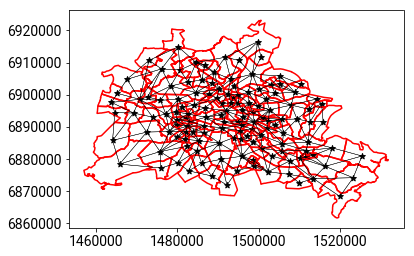

In [20]:
Qconnected.plot(neighbourhoods, node_kws=dict(marker='*'), edge_kws=dict(linewidth=.4))
neighbourhoods.boundary.plot(color='r', ax=plt.gca())

In addition, we could use the `lp.w_subset` function:

In [21]:
Qconnected2 = lp.w_subset(Qneighbs, ids=[i for i in range(Qneighbs.n) if labels[i] == 0])

Sometimes, if pandas rearranges the dataframes, these will appear to be different weights, since the ordering is different. To check if two weights objects are identical, a simple test is to check the sparse matrices for **in**equality:

In [22]:
(Qconnected2.sparse != Qconnected.sparse).sum()

0

### Alternative Representations

PySAL, by default, tends to focus on a single `W` object, which provides easy tools to construct & work with the accompanying sparse matrix representations. 

However, it's often the case we want alternative representations of the same relationships. 

One handy one is the weights list. This is an alternative form of expressing a weights matrix, and provides a copy of the underlying `W.sparse.data`, made more regular and put into a pandas dataframe.  

In [53]:
adjlist = Qconnected.to_adjlist()
adjlist.head()

,focal,neighbor,weight
0,0,23,1.0
1,0,9,1.0
2,0,27,1.0
3,0,12,1.0
4,0,29,1.0


This handy if you'd rather work with the representation in terms of individual edges, rather than in sets of edges. 

Also, it is exceptionally handy when you want to ask questions about the data used to generate the spatial weights, since it lets you attach this data to each of the focal pairs and ask questions about the associated data at that level. 

For example, say we get the median price of airbnbs within a given neighbourhood:

In [24]:
hoodprice = listings.groupby("neighbourhood_cleansed").price.median().to_frame()

In [25]:
hoodprice.head()

,price
neighbourhood_cleansed,
Adlershof,37.0
Albrechtstr.,35.0
Alexanderplatz,65.0
Allende-Viertel,21.0
Alt Treptow,43.5


In [26]:
neighbourhoods = neighbourhoods.merge(
                           hoodprice,
                           left_on='neighbourhood', right_index=True, how='left')

In [27]:
neighbourhoods = neighbourhoods.rename(columns=dict(price='median_price'))

Then, we map this:

/home/lw17329/anaconda/envs/gds/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


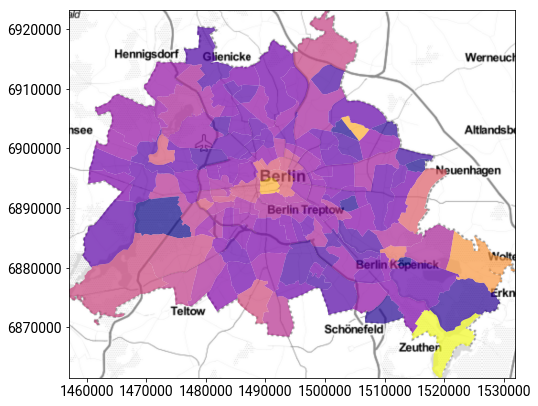

In [28]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
# when you only want to plot the boundaries:
neighbourhoods.plot('median_price', cmap='plasma', alpha=.7, ax=ax)
#basemap of the area
ax.imshow(basemap, extent=bounds, interpolation='gaussian')
ax.axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
#if you want the highest values to show on top of lower ones
plt.show()

We could measure the differences only in adjacent neighbourhood's prices by merging this information back up to the adjacency list. 

Usually, these joins involve building links between both the focal and neighbor observation IDs. You can do this simply by stringing together two merges: one that focuses on the "focal" index and one that focuses on the "neighbor" index.

Using a suffix in the last argument will disambiguate the data joined on the focal index to the data joined on the neighbor index. 

In [54]:
adjlist = adjlist.merge(neighbourhoods[['neighbourhood', 
                                        'median_price']], 
                        left_on='focal', right_index=True, how='left')\
                  .merge(neighbourhoods[['neighbourhood', 
                                         'median_price']], 
                         left_on='neighbor', right_index=True ,how='right', 
                         suffixes=('_focal', '_neighbor'))

Then, we can group by the `focal` index and take the difference of the prices. 

In [55]:
pricediff = adjlist[['median_price_focal', 
                     'median_price_neighbor']].diff(axis=1)

In [56]:
pricediff.head()

,median_price_focal,median_price_neighbor
0,NaN,1.5
47,NaN,-18.5
148,NaN,-10.0
167,NaN,-6.0
1,NaN,20.0


We can link this back up to the original adjacency list, but first let's rename the column we want to `price_difference` and only keep that column:

In [57]:
pricediff['price_difference'] = pricediff[['median_price_neighbor']]
adjlist['price_difference'] = pricediff[['price_difference']]

And, if we wanted to find the pair of adjacent neighbourhoods with the greatest price difference:

In [58]:
adjlist.head()

,focal,neighbor,weight,neighbourhood_focal,median_price_focal,neighbourhood_neighbor,median_price_neighbor,price_difference
0,0,23,1.0,Blankenfelde/Niederschönhausen,37.5,Buchholz,39.0,1.5
47,9,23,1.0,Buch,57.5,Buchholz,39.0,-18.5
148,26,23,1.0,Blankenburg/Heinersdorf/Märchenland,49.0,Buchholz,39.0,-10.0
167,29,23,1.0,Pankow Zentrum,45.0,Buchholz,39.0,-6.0
1,0,9,1.0,Blankenfelde/Niederschönhausen,37.5,Buch,57.5,20.0


Now, we can group by *both* the focal and neighbor name to get a meaningful list of all the neighborhood boundaries & their difference in median listing price. 

In [108]:
contrasts = adjlist.groupby(("neighbourhood_focal", 
                 "neighbourhood_neighbor")).price_difference\
                .median().abs().sort_values().to_frame().reset_index()

For about twenty neighbourhood pairs (since these will be duplicate `(A,B) & (B,A)` links), the median listing price is the same:

In [109]:
contrasts.query('price_difference == 0').sort_values(['neighbourhood_focal','neighbourhood_neighbor'])

,neighbourhood_focal,neighbourhood_neighbor,price_difference
9,Alt-Hohenschönhausen Süd,Weißensee Ost,0.0
24,Baumschulenweg,Britz,0.0
20,Baumschulenweg,Oberschöneweide,0.0
8,Britz,Baumschulenweg,0.0
33,Düsseldorfer Straße,Neue Kantstraße,0.0
34,Falkenhagener Feld,Hakenfelde,0.0
23,Frankfurter Allee Süd,Friedrichsfelde Nord,0.0
0,Frankfurter Allee Süd FK,Karl-Marx-Allee-Süd,0.0
3,Friedrichsfelde Nord,Frankfurter Allee Süd,0.0
11,Friedrichshagen,Köpenick-Nord,0.0


On the other end, the 20 largest paired differences in median price between adjacent neighbourhoods is shown below:

In [110]:
contrasts.sort_values(['price_difference',
                       'neighbourhood_focal'],
                       ascending=[False,True]).head(40)

,neighbourhood_focal,neighbourhood_neighbor,price_difference
757,Müggelheim,Schmöckwitz/Karolinenhof/Rauchfangswerder,74.0
756,Schmöckwitz/Karolinenhof/Rauchfangswerder,Müggelheim,74.0
754,Neu-Hohenschönhausen Nord,Neu-Hohenschönhausen Süd,62.5
755,Neu-Hohenschönhausen Süd,Neu-Hohenschönhausen Nord,62.5
753,Grünau,Schmöckwitz/Karolinenhof/Rauchfangswerder,59.0
752,Schmöckwitz/Karolinenhof/Rauchfangswerder,Grünau,59.0
751,Müggelheim,Rahnsdorf/Hessenwinkel,55.0
750,Rahnsdorf/Hessenwinkel,Müggelheim,55.0
748,"Malchow, Wartenberg und Falkenberg",Neu-Hohenschönhausen Nord,50.0
749,Neu-Hohenschönhausen Nord,"Malchow, Wartenberg und Falkenberg",50.0


## More representations

There are similarly more representations available and currently under development, such as a networkx interface in `W.to_networkx/W.from_networkx`. 

## Contiguity for points

Contiguity can also make sense for point objects as well, if you think about the corresponding Voronoi Diagram and the Thiessen Polygons's adjacency graph. 

Effectively, this connects each point to a set of its nearest neighbouring points, without pre-specifying the number of points.

We can use it to define relationships between airbnb listings in our dataset. 

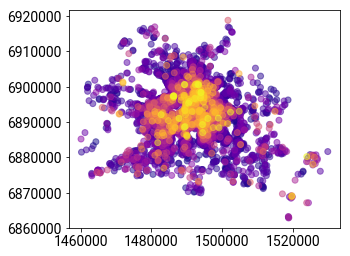

In [112]:
listings.sort_values('price').plot('price', cmap='plasma', alpha=.5)

In [113]:
from libpysal.weights.user import voronoiW,voronoi_frames

In [114]:
coordinates = np.vstack((listings.centroid.x, listings.centroid.y)).T

In [115]:
thiessens, points = voronoi_frames(coordinates)

However, the "natural" polygons generated by the `scipy.distance.voronoi` object may be excessively big, since some of the nearly-parallel lines in the voronoi diagram may take a long time to intersect. 

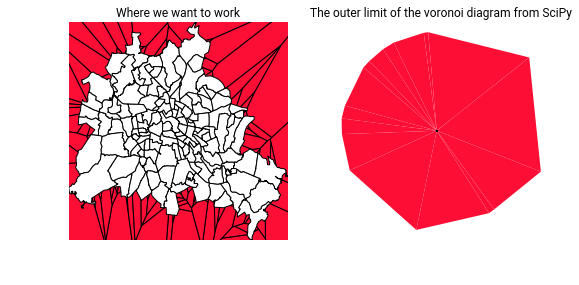

In [116]:
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
thiessens.plot(ax=ax[0], edgecolor='k')
neighbourhoods.plot(ax=ax[0], color='w', edgecolor='k')
ax[0].axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Where we want to work")
thiessens.plot(ax=ax[1])
neighbourhoods.plot(ax=ax[1], color='w', edgecolor='k')
ax[1].set_title("The outer limit of the voronoi diagram from SciPy")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

Fortunately, PySAL can work with this amount of observations to build weights really quickly. But, the `geopandas` overlay operation is very slow for this many polygons, so even with a spatial index, clipping these polygons to the bounding box can take a bit...

In [117]:
thiessens.shape

(20053, 1)

So, I've precomputed the clipped version of the thiessen polygons and stored them, so that we can move forward without waiting too long

In [129]:
clipped_thiessens = gpd.read_file('./data/thiessens.shp')

Note that, whereas the overlay operation to clean up this diagram took quite a bit of computation time if just called regularly ([and there may be plenty faster ways to do these kinds of ops](http://2018.geopython.net/#w4)), constructing the topology for all 20k Thiessen polygons is rather fast:

In [130]:
Qthiessens = lp.Queen.from_dataframe(thiessens)

Just to show what this looks like, I'll plot one of the neighbourhoods in Berlin. 

In [175]:
pberg = thiessens[listings.neighbourhood_cleansed == 'Prenzlauer Berg Nord']
pberg = pberg.reset_index()

Here, I'm going to use a `Rook` contiguity criterion, which means that touching at a single point is not sufficient to consider two thiessen polygons as "neighboring."

In [208]:
Rthiessens_pberg = lp.Rook.from_dataframe(pberg)

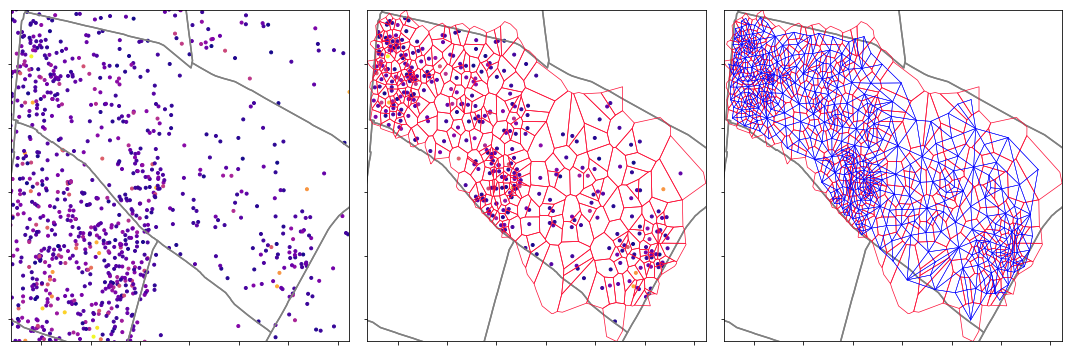

In [215]:
f,ax = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

# plot the airbnbs across the map

listings.plot('price', cmap='plasma', ax=ax[0],zorder=0, marker='.')
# Focus on pberg
ax[0].set_xlim(*pberg.total_bounds[np.asarray([0,2])])
ax[0].set_ylim(*pberg.total_bounds[np.asarray([1,3])])

# Plot the thiessens corresponding to each listing in pberg north
listings[listings.neighbourhood_cleansed == 'Prenzlauer Berg Nord']\
        .plot('price', cmap='plasma', marker='.', ax=ax[1], zorder=0)
pberg.boundary.plot(ax=ax[1], linewidth=.7)
    
# plot the thiessens and their representative network linking each airbnb
Rthiessens_pberg.plot(pberg, node_kws=dict(marker='.',s=0), 
                      edge_kws=dict(linewidth=.5), color='b', ax=ax[2])
pberg.boundary.plot(ax=ax[2], linewidth=.7)

# underlay the neighbourhood boundaries
for ax_ in ax:
    neighbourhoods.boundary.plot(ax=ax_, color='grey',zorder=1)
    ax_.set_xticklabels([])
    ax_.set_yticklabels([])
f.tight_layout()
plt.show()

# Distance